In [1]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m

In [2]:
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet50, ResNet50_Weights


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [14]:
class HAA_dataset(Dataset):
    "Video frame Dataset"
    def __init__(self,data_dir,usage='train'):
        self.data_dir = data_dir
        self.categories = os.listdir(self.data_dir)
        self.categories.sort()
        self.n_cat = len(self.categories)
        self.usage = usage
        
        if self.usage=='train':
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        else:
            seed = 42
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        frames = []
        for category in self.categories:
            folder_frames = [frame for frame in os.listdir(os.path.join(data_dir,category)) if not frame.startswith('.')]
            folder_frames.sort()
            frames.append(folder_frames)
        self.frames = frames
        
        self.Ts = transforms.Compose([transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3, hue=.3),
        transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 2.0))])
        
    def __len__(self):
        return 10_000 # 
        
    def __getitem__(self, idx):
        
        #data_dir = './Data/pytorch-data/action_data_orig/train'
        self.rand_cat = np.random.randint(low=0,high=self.n_cat)
        self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        im = Ts(im)
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        #sample = {'image': torch.from_numpy(image).float(), 'label': torch.from_numpy(label).float()}  # make a dict with the image and the correct label
        sample = {'image': torch.from_numpy(im).float(), 'label': torch.from_numpy(np.array([self.rand_cat])).float()}  # make a dict with the image and the correct label
        return sample
    
    
    def get_im(self,rand_cat):
        self.rand_cat = rand_cat
        self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        im = self.Ts(im)
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        return im
    
    def get_batch(self,batch_size):
        self.this_batch_cats = np.random.randint(low=0,high=self.n_cat,size=batch_size)
        self.this_batch_cats = np.array(self.this_batch_cats)
        self.this_batch_im = [self.get_im(i) for i in self.this_batch_cats]
        self.this_batch_im = np.array(self.this_batch_im)
        sample = {'image': torch.from_numpy(self.this_batch_im).float(), 'label': torch.from_numpy(self.this_batch_cats).float()}  # make a dict with the image and the correct label
        return sample

In [15]:
def get_acc(which_dataset):
    net.eval();
    
    ncat = 45
    nrep = 10
    test_res = np.zeros((nrep,ncat))
    
    for c in range(ncat):
        for rep in range(nrep):
            test_im = torch.from_numpy(which_dataset.get_im(c)[np.newaxis,:,:,:]).half().cuda()
            test_pred = net(test_im)
            test_pred = np.array(test_pred.cpu().detach().numpy())[0,:]
            test_res[rep,c] = np.argmax(test_pred)==c
        
    return test_res.mean(axis=0).mean()

In [16]:
data_dir = './Data/pytorch-data/action_data_orig/train'
train_dataset = HAA_dataset(data_dir,usage='train')

In [17]:
val_dataset = HAA_dataset('./Data/pytorch-data/action_data_orig/val',usage='val')
test_dataset = HAA_dataset('./Data/pytorch-data/action_data_orig/val',usage='test')

In [18]:
net = resnet50()
net.fc = nn.Linear(net.fc.in_features,train_dataset.n_cat)

net = net.to(device)
net = net.half()

In [19]:
criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [20]:
#val_data = val_dataset.get_batch(64)
val_data = val_dataset.get_batch(32)
val_images = val_data['image'].half()
val_labels = val_data['label'].half()
tmp = []
tmp = torch.squeeze(val_labels.long())
val_images, val_labels = val_images.cuda(),  tmp.cuda()

In [21]:
save_freq = 5                               # specify every how many epochs to save the model
#net.train()                                 # put the network in "training mode" (let's not worry about this for now)
loss_memory = []
val_memory = []
n_batches = 50
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()
    for _ in range(n_batches):
        #torch.cuda.empty_cache() 
        # get the inputs
        data = train_dataset.get_batch(32)
        images = data['image'].half()
        labels = data['label'].half()
        tmp = []
        tmp = torch.squeeze(labels.long())
        images, labels = images.cuda(),  tmp.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
    epoch_loss = running_loss / n_batches
    loss_memory.append(epoch_loss)
    running_loss = 0.0
    
    net.eval();
    val_outputs = net(val_images)
    val_loss = criterion(val_outputs, val_labels)
    val_memory.append(val_loss.data.item())
    
    val_acc = get_acc(val_dataset)
    train_acc = get_acc(train_dataset)
    
    print(f'epoch [{epoch}], train loss {epoch_loss:.2f}, ValLoss [{val_loss:.2f}], ValAcc [{val_acc:.4f}], TrainAcc [{train_acc:.4f}]')    

epoch [0], train loss 3.97, ValLoss [5.21], ValAcc [0.0089], TrainAcc [0.0289]
epoch [1], train loss 3.94, ValLoss [4.33], ValAcc [0.0156], TrainAcc [0.0244]
epoch [2], train loss 3.94, ValLoss [4.25], ValAcc [0.0267], TrainAcc [0.0244]
epoch [3], train loss 3.94, ValLoss [4.36], ValAcc [0.0267], TrainAcc [0.0311]
epoch [4], train loss 3.90, ValLoss [4.11], ValAcc [0.0244], TrainAcc [0.0444]
epoch [5], train loss 3.88, ValLoss [4.39], ValAcc [0.0200], TrainAcc [0.0356]
epoch [6], train loss 3.84, ValLoss [4.08], ValAcc [0.0422], TrainAcc [0.0378]
epoch [7], train loss 3.83, ValLoss [4.25], ValAcc [0.0178], TrainAcc [0.0400]
epoch [8], train loss 3.81, ValLoss [4.00], ValAcc [0.0200], TrainAcc [0.0733]
epoch [9], train loss 3.78, ValLoss [3.88], ValAcc [0.0356], TrainAcc [0.0467]
epoch [10], train loss 3.77, ValLoss [4.12], ValAcc [0.0267], TrainAcc [0.0556]
epoch [11], train loss 3.73, ValLoss [3.80], ValAcc [0.0311], TrainAcc [0.0778]
epoch [12], train loss 3.66, ValLoss [3.84], ValAc

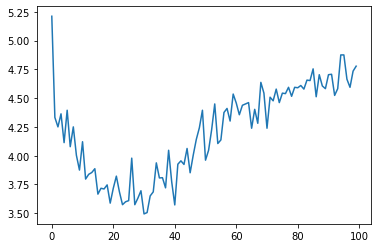

In [23]:
plt.plot(val_memory)